<a href="https://www.kaggle.com/code/luminlab/ber-curation?scriptVersionId=182379458" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://www.kaggle.com/code/luminlab/ber-curation?scriptVersionId=182257992" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Details of Steps can be found on Google Slides via:¶

https://docs.google.com/presentation/d/1sb3QkXiYooHqi3p-tkGVUqwqFKd-601_pzU96W1drw0/edit?usp=sharing

In [3]:
from kaggle_secrets import UserSecretsClient
wandb_key_label = "WANDB_KEY"
wandb_key= UserSecretsClient().get_secret(wandb_key_label)

In [4]:
import git
git.Repo.clone_from('https://github.com/Lumin-Lab/BerCuration', '/kaggle/working/scarf')

<git.repo.base.Repo '/kaggle/working/scarf/.git'>

In [5]:
!pip install -r /kaggle/working/scarf/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 88.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 46.2 MB/s eta 0:00:0000:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.3/352.3 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 73.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 66.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 35.2 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [6]:
import os
def save_csv_file(df, path):
    dir_name = os.path.dirname(path)
    if dir_name:
        if not os.path.exists(dir_name):
            os.makedirs(dir_name)
    df.to_csv(path, index=False)

In [7]:
import pandas as pd
df = pd.read_csv("/kaggle/input/ber-stratified-samples/BER_stratified_sample.csv")

/tmp/ipykernel_34/2556053210.py:2: DtypeWarning: Columns (156,162,167) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/kaggle/input/ber-stratified-samples/BER_stratified_sample.csv")


In [8]:
n_splits = 5
output_dir = "/kaggle/working/output"
config_dir="/kaggle/working/scarf/configs"
scarf_model_name = "scarf"
mlp_model_name = "mlp"

In [9]:
from sklearn.model_selection import KFold
import os
kf = KFold(n_splits=n_splits, random_state=42, shuffle=True)
for i, (train_index, test_index) in enumerate(kf.split(df)):
    save_csv_file(df.iloc[train_index], f"{output_dir}/split_{i+1}/raw_train.csv")
    save_csv_file(df.iloc[test_index], f"{output_dir}/split_{i+1}/raw_test.csv")

In [10]:
for i in range(n_splits):
    command = f"""
    python /kaggle/working/scarf/get_processed_dataset.py \
      --config_dir "/kaggle/working/scarf/configs" \
      --output_dir "{output_dir}/split_{i+1}" \
      --data_path "{output_dir}/split_{i+1}/raw_train.csv" \
      --output_csv_name "processed_train" \
      --is_train
    """
    os.system(command)
    command = f"""
    python /kaggle/working/scarf/get_processed_dataset.py \
      --config_dir "/kaggle/working/scarf/configs" \
      --output_dir "{output_dir}/split_{i+1}" \
      --data_path "{output_dir}/split_{i+1}/raw_test.csv" \
      --output_csv_name "processed_test"
    """
    os.system(command)

**Train the SCARF Encoder on the Train Dataset**

In [11]:
scarf_batch_size = 32
scarf_epochs = 25
scarf_lr = 3e-5
scarf_emb_dim = 32
scarf_encoder_depth = 3
scarf_corruption_rate=0.3

In [12]:
import os
"""The trained scarf model is saved in 
/kaggle/working/output/split_{split}/scarf.pt if you run the following command:
"""
for i in range(n_splits):
    command = f"""
    python /kaggle/working/scarf/run_scarf.py\
      --config_dir={config_dir} \
      --output_dir="{output_dir}/split_{i+1}" \
      --train_data_path="{output_dir}/split_{i+1}/processed_train.csv"\
      --batch_size={scarf_batch_size} \
      --epochs={scarf_epochs} \
      --lr={scarf_lr} \
      --emb_dim={scarf_emb_dim} \
      --encoder_depth={scarf_encoder_depth} \
      --model_name="{scarf_model_name}" \
      --corruption_rate={scarf_corruption_rate} \
      --wandb_project_name='SCARF_Project' \
      --wandb_entity='urbancomp' \
      --wandb_key='{wandb_key}'
    """

    os.system(command)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dan-liu (urbancomp). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240609_121137-4x4q47et
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run SCARF_Project
wandb: ⭐️ View project at https://wandb.ai/urbancomp/Scarf
wandb: 🚀 View run at https://wandb.ai/urbancomp/Scarf/runs/4x4q47et


Epoch [1/25] - Train Loss: 2.950
Model saved at /kaggle/working/output/split_1/scarf.pt
Epoch [2/25] - Train Loss: 2.916
Model saved at /kaggle/working/output/split_1/scarf.pt
Epoch [3/25] - Train Loss: 2.964
Epoch [4/25] - Train Loss: 2.940
Epoch [5/25] - Train Loss: 2.894
Model saved at /kaggle/working/output/split_1/scarf.pt
Epoch [6/25] - Train Loss: 2.917
Epoch [7/25] - Train Loss: 2.849
Model saved at /kaggle/working/output/split_1/scarf.pt
Epoch [8/25] - Train Loss: 2.819
Model saved at /kaggle/working/output/split_1/scarf.pt
Epoch [9/25] - Train Loss: 2.962
Epoch [10/25] - Train Loss: 2.839
Epoch [11/25] - Train Loss: 2.900
Epoch [12/25] - Train Loss: 2.861
Epoch [13/25] - Train Loss: 2.904
Epoch [14/25] - Train Loss: 2.862
Epoch [15/25] - Train Loss: 2.846
Epoch [16/25] - Train Loss: 2.828
Epoch [17/25] - Train Loss: 2.905
Epoch [18/25] - Train Loss: 2.796
Model saved at /kaggle/working/output/split_1/scarf.pt
Epoch [19/25] - Train Loss: 2.870
Epoch [20/25] - Train Loss: 2.920

wandb: | 0.020 MB of 0.020 MB uploaded
wandb: Run history:
wandb: encoder_train/train_loss ██▆▇▄▄▃▄▅▄▄▂▃▃▁▄▄▄▃▂▃▂▂▂▃▁▂▃▂▂▃▁▂▃▂▂▃▂▂▃
wandb: 
wandb: Run summary:
wandb: encoder_train/train_loss 3.36456
wandb: 
wandb: 🚀 View run SCARF_Project at: https://wandb.ai/urbancomp/Scarf/runs/4x4q47et
wandb: ⭐️ View project at: https://wandb.ai/urbancomp/Scarf
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20240609_121137-4x4q47et/logs
wandb: Currently logged in as: dan-liu. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dan-liu (urbancomp). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.1 i

Epoch [1/25] - Train Loss: 2.895
Model saved at /kaggle/working/output/split_2/scarf.pt
Epoch [2/25] - Train Loss: 2.932
Epoch [3/25] - Train Loss: 2.922
Epoch [4/25] - Train Loss: 2.905
Epoch [5/25] - Train Loss: 2.841
Model saved at /kaggle/working/output/split_2/scarf.pt
Epoch [6/25] - Train Loss: 2.983
Epoch [7/25] - Train Loss: 2.841
Epoch [8/25] - Train Loss: 2.820
Model saved at /kaggle/working/output/split_2/scarf.pt
Epoch [9/25] - Train Loss: 2.848
Epoch [10/25] - Train Loss: 2.858
Epoch [11/25] - Train Loss: 2.845
Epoch [12/25] - Train Loss: 2.929
Epoch [13/25] - Train Loss: 2.865
Epoch [14/25] - Train Loss: 2.816
Model saved at /kaggle/working/output/split_2/scarf.pt
Epoch [15/25] - Train Loss: 2.817
Epoch [16/25] - Train Loss: 2.807
Model saved at /kaggle/working/output/split_2/scarf.pt
Epoch [17/25] - Train Loss: 2.877
Epoch [18/25] - Train Loss: 2.881
Epoch [19/25] - Train Loss: 2.845
Epoch [20/25] - Train Loss: 2.795
Model saved at /kaggle/working/output/split_2/scarf.pt

wandb: | 0.020 MB of 0.020 MB uploaded
wandb: Run history:
wandb: encoder_train/train_loss █▃▆█▆▄▄▄▂▄▃▁▄▃▃▄▂▃▂▃▃▃▃▂▁▃▃▃▄▄▂▅▁▂▁▂▁▁▄▄
wandb: 
wandb: Run summary:
wandb: encoder_train/train_loss 3.36593
wandb: 
wandb: 🚀 View run SCARF_Project at: https://wandb.ai/urbancomp/Scarf/runs/k3qvyqga
wandb: ⭐️ View project at: https://wandb.ai/urbancomp/Scarf
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20240609_122043-k3qvyqga/logs
wandb: Currently logged in as: dan-liu. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dan-liu (urbancomp). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.1 i

Epoch [1/25] - Train Loss: 2.866
Model saved at /kaggle/working/output/split_3/scarf.pt
Epoch [2/25] - Train Loss: 2.908
Epoch [3/25] - Train Loss: 2.904
Epoch [4/25] - Train Loss: 2.893
Epoch [5/25] - Train Loss: 2.911
Epoch [6/25] - Train Loss: 2.888
Epoch [7/25] - Train Loss: 2.824
Model saved at /kaggle/working/output/split_3/scarf.pt
Epoch [8/25] - Train Loss: 2.841
Epoch [9/25] - Train Loss: 2.913
Epoch [10/25] - Train Loss: 2.874
Epoch [11/25] - Train Loss: 2.874
Epoch [12/25] - Train Loss: 2.864
Epoch [13/25] - Train Loss: 2.828
Epoch [14/25] - Train Loss: 2.861
Epoch [15/25] - Train Loss: 2.865
Epoch [16/25] - Train Loss: 2.772
Model saved at /kaggle/working/output/split_3/scarf.pt
Epoch [17/25] - Train Loss: 2.842
Epoch [18/25] - Train Loss: 2.852
Epoch [19/25] - Train Loss: 2.849
Epoch [20/25] - Train Loss: 2.859
Epoch [21/25] - Train Loss: 2.817
Epoch [22/25] - Train Loss: 2.861
Epoch [23/25] - Train Loss: 2.798
Epoch [24/25] - Train Loss: 2.806
Epoch [25/25] - Train Loss: 

wandb: | 0.020 MB of 0.020 MB uploaded
wandb: Run history:
wandb: encoder_train/train_loss ▆█▆▅▃▃▃▂▃▄▄▂▃▂▃▄▅▁▃▁▂▂▃▅▃▂▂▂▂▁▁▃▃▁▁▃▂▃▂▃
wandb: 
wandb: Run summary:
wandb: encoder_train/train_loss 3.34134
wandb: 
wandb: 🚀 View run SCARF_Project at: https://wandb.ai/urbancomp/Scarf/runs/ncdrudkl
wandb: ⭐️ View project at: https://wandb.ai/urbancomp/Scarf
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20240609_122946-ncdrudkl/logs
wandb: Currently logged in as: dan-liu. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dan-liu (urbancomp). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.1 i

Epoch [1/25] - Train Loss: 2.970
Model saved at /kaggle/working/output/split_4/scarf.pt
Epoch [2/25] - Train Loss: 2.896
Model saved at /kaggle/working/output/split_4/scarf.pt
Epoch [3/25] - Train Loss: 2.852
Model saved at /kaggle/working/output/split_4/scarf.pt
Epoch [4/25] - Train Loss: 2.824
Model saved at /kaggle/working/output/split_4/scarf.pt
Epoch [5/25] - Train Loss: 2.836
Epoch [6/25] - Train Loss: 2.895
Epoch [7/25] - Train Loss: 2.865
Epoch [8/25] - Train Loss: 2.825
Epoch [9/25] - Train Loss: 2.875
Epoch [10/25] - Train Loss: 2.877
Epoch [11/25] - Train Loss: 2.842
Epoch [12/25] - Train Loss: 2.844
Epoch [13/25] - Train Loss: 2.916
Epoch [14/25] - Train Loss: 2.883
Epoch [15/25] - Train Loss: 2.802
Model saved at /kaggle/working/output/split_4/scarf.pt
Epoch [16/25] - Train Loss: 2.850
Epoch [17/25] - Train Loss: 2.919
Epoch [18/25] - Train Loss: 2.887
Epoch [19/25] - Train Loss: 2.845
Epoch [20/25] - Train Loss: 2.809
Epoch [21/25] - Train Loss: 2.874
Epoch [22/25] - Trai

wandb: | 0.020 MB of 0.020 MB uploaded
wandb: Run history:
wandb: encoder_train/train_loss ██▆▅▆▄▃▃▃▃▆▂▃▄▃▄▂▃▂▂▁▅▃▂▂▂▂▂▂▂▂▃▃▂▃▃▂▂▃▃
wandb: 
wandb: Run summary:
wandb: encoder_train/train_loss 3.32034
wandb: 
wandb: 🚀 View run SCARF_Project at: https://wandb.ai/urbancomp/Scarf/runs/n7ezs2qk
wandb: ⭐️ View project at: https://wandb.ai/urbancomp/Scarf
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20240609_123853-n7ezs2qk/logs
wandb: Currently logged in as: dan-liu. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dan-liu (urbancomp). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.1 i

Epoch [1/25] - Train Loss: 2.985
Model saved at /kaggle/working/output/split_5/scarf.pt
Epoch [2/25] - Train Loss: 2.916
Model saved at /kaggle/working/output/split_5/scarf.pt
Epoch [3/25] - Train Loss: 3.036
Epoch [4/25] - Train Loss: 3.085
Epoch [5/25] - Train Loss: 2.925
Epoch [6/25] - Train Loss: 2.920
Epoch [7/25] - Train Loss: 2.837
Model saved at /kaggle/working/output/split_5/scarf.pt
Epoch [8/25] - Train Loss: 2.905
Epoch [9/25] - Train Loss: 2.899
Epoch [10/25] - Train Loss: 2.855
Epoch [11/25] - Train Loss: 2.858
Epoch [12/25] - Train Loss: 2.855
Epoch [13/25] - Train Loss: 3.008
Epoch [14/25] - Train Loss: 2.858
Epoch [15/25] - Train Loss: 2.989
Epoch [16/25] - Train Loss: 2.848
Epoch [17/25] - Train Loss: 2.974
Epoch [18/25] - Train Loss: 2.912
Epoch [19/25] - Train Loss: 2.878
Epoch [20/25] - Train Loss: 2.943
Epoch [21/25] - Train Loss: 2.958
Epoch [22/25] - Train Loss: 2.890
Epoch [23/25] - Train Loss: 2.960
Epoch [24/25] - Train Loss: 2.859
Epoch [25/25] - Train Loss: 

wandb: | 0.020 MB of 0.020 MB uploaded
wandb: Run history:
wandb: encoder_train/train_loss █▅▅▄▄▅▃▃▂▄▄▂▃▁▃▃▂▃▂▃▃▂▁▃▂▂▂▂▁▂▂▂▁▃▂▁▃▂▁▁
wandb: 
wandb: Run summary:
wandb: encoder_train/train_loss 3.32775
wandb: 
wandb: 🚀 View run SCARF_Project at: https://wandb.ai/urbancomp/Scarf/runs/09x21huj
wandb: ⭐️ View project at: https://wandb.ai/urbancomp/Scarf
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20240609_124802-09x21huj/logs


**Obtain the SCARF embeddings for different train splits, and save the result**

In [13]:
"""The generated embeddings are saved as a NumPy array in 
/kaggle/working/output/split_{split}/train.npy if you run the following command:
"""
for i in range(n_splits):
    command = f"""
    python /kaggle/working/scarf/get_scarf_embedding.py \
      --config_dir={config_dir} \
      --output_dir="{output_dir}/split_{i+1}" \
      --data_path="{output_dir}/split_{i+1}/processed_train.csv" \
      --batch_size={scarf_batch_size} \
      --epochs={scarf_epochs} \
      --lr={scarf_lr} \
      --emb_dim={scarf_emb_dim} \
      --encoder_depth={scarf_encoder_depth} \
      --model_name={scarf_model_name} \
      --corruption_rate={scarf_corruption_rate} \
      --embedding_save_name="train"
    """

    os.system(command)

Model loaded from /kaggle/working/output/split_1/scarf.pt
Model loaded from /kaggle/working/output/split_2/scarf.pt
Model loaded from /kaggle/working/output/split_3/scarf.pt
Model loaded from /kaggle/working/output/split_4/scarf.pt
Model loaded from /kaggle/working/output/split_5/scarf.pt


**Obtain the SCARF embeddings for different test splits, and save the result**

In [14]:
"""The generated embeddings are saved as a NumPy array in 
/kaggle/working/output/split_{split}/test.npy if you run the following command:
"""
for i in range(n_splits):
    command = f"""
    python /kaggle/working/scarf/get_scarf_embedding.py \
      --config_dir={config_dir} \
      --output_dir="{output_dir}/split_{i+1}" \
      --data_path="{output_dir}/split_{i+1}/processed_test.csv" \
      --batch_size={scarf_batch_size} \
      --epochs={scarf_epochs} \
      --lr={scarf_lr} \
      --emb_dim={scarf_emb_dim} \
      --encoder_depth={scarf_encoder_depth} \
      --model_name={scarf_model_name} \
      --corruption_rate={scarf_corruption_rate} \
      --embedding_save_name="test"
    """

    os.system(command)

Model loaded from /kaggle/working/output/split_1/scarf.pt
Model loaded from /kaggle/working/output/split_2/scarf.pt
Model loaded from /kaggle/working/output/split_3/scarf.pt
Model loaded from /kaggle/working/output/split_4/scarf.pt
Model loaded from /kaggle/working/output/split_5/scarf.pt


**Filter outliers based on scarf embeddings**

In [15]:
threshold = 0.3

In [16]:
label_map = {
    0: 'A1',
    1: 'A2',
    2: 'A3',
    3: 'B1',
    4: 'B2',
    5: 'B3',
    6: 'C1',
    7: 'C2',
    8: 'C3',
    9: 'D1',
    10: 'D2',
    11: 'E1',
    12: 'E2',
    13: 'F',
    14: 'G'
}

In [17]:
import matplotlib.pyplot as plt
def plot_data(data, labels, circles, title, alpha=1.0):
    
    colormap = plt.cm.tab20
    colors = {str(label): colormap(i) for i, label in enumerate(set(labels))}

    plt.figure(figsize=(14, 5))
    done = set()
    for i in range(0,len(data)):
        lab = str(labels[i])
        label_name = label_map[int(lab)]
        if label_name in done:
            label = ""
        else:
            label = label_name
            done.add(label_name)
        plt.scatter(data[i, 0], data[i, 1],  c=colors[lab], s=30,alpha=0.6, 
                    label = label)
    for i in circles:
        plt.plot(
            data[i][0],
            data[i][1],
            "o",
            markerfacecolor="none",
            markeredgecolor="red",
            markersize=14,
            markeredgewidth=2.5,
            alpha=alpha
        )
    _ = plt.title(title, fontsize=25)
    plt.legend()

Fitting OOD estimator based on provided features ...


/tmp/ipykernel_34/4118904960.py:14: DtypeWarning: Columns (156,162,167) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(f"{output_dir}/split_{i+1}/raw_train.csv")
/tmp/ipykernel_34/4118904960.py:15: DtypeWarning: Columns (156,162) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv(f"{output_dir}/split_{i+1}/raw_test.csv")
/tmp/ipykernel_34/2297181836.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(data[i, 0], data[i, 1],  c=colors[lab], s=30,alpha=0.6,


Fitting OOD estimator based on provided features ...


/tmp/ipykernel_34/4118904960.py:14: DtypeWarning: Columns (156,162,167) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(f"{output_dir}/split_{i+1}/raw_train.csv")
/tmp/ipykernel_34/4118904960.py:15: DtypeWarning: Columns (162) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv(f"{output_dir}/split_{i+1}/raw_test.csv")
/tmp/ipykernel_34/2297181836.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(data[i, 0], data[i, 1],  c=colors[lab], s=30,alpha=0.6,


Fitting OOD estimator based on provided features ...


/tmp/ipykernel_34/4118904960.py:14: DtypeWarning: Columns (156,162,167) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(f"{output_dir}/split_{i+1}/raw_train.csv")
/tmp/ipykernel_34/4118904960.py:15: DtypeWarning: Columns (162) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv(f"{output_dir}/split_{i+1}/raw_test.csv")
/tmp/ipykernel_34/2297181836.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(data[i, 0], data[i, 1],  c=colors[lab], s=30,alpha=0.6,


Fitting OOD estimator based on provided features ...


/tmp/ipykernel_34/4118904960.py:14: DtypeWarning: Columns (156,162,167) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(f"{output_dir}/split_{i+1}/raw_train.csv")
/tmp/ipykernel_34/4118904960.py:15: DtypeWarning: Columns (162) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv(f"{output_dir}/split_{i+1}/raw_test.csv")
/tmp/ipykernel_34/2297181836.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(data[i, 0], data[i, 1],  c=colors[lab], s=30,alpha=0.6,


Fitting OOD estimator based on provided features ...


/tmp/ipykernel_34/4118904960.py:14: DtypeWarning: Columns (156,162) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(f"{output_dir}/split_{i+1}/raw_train.csv")
/tmp/ipykernel_34/4118904960.py:15: DtypeWarning: Columns (156,162,167) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv(f"{output_dir}/split_{i+1}/raw_test.csv")
/tmp/ipykernel_34/2297181836.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(data[i, 0], data[i, 1],  c=colors[lab], s=30,alpha=0.6,
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts

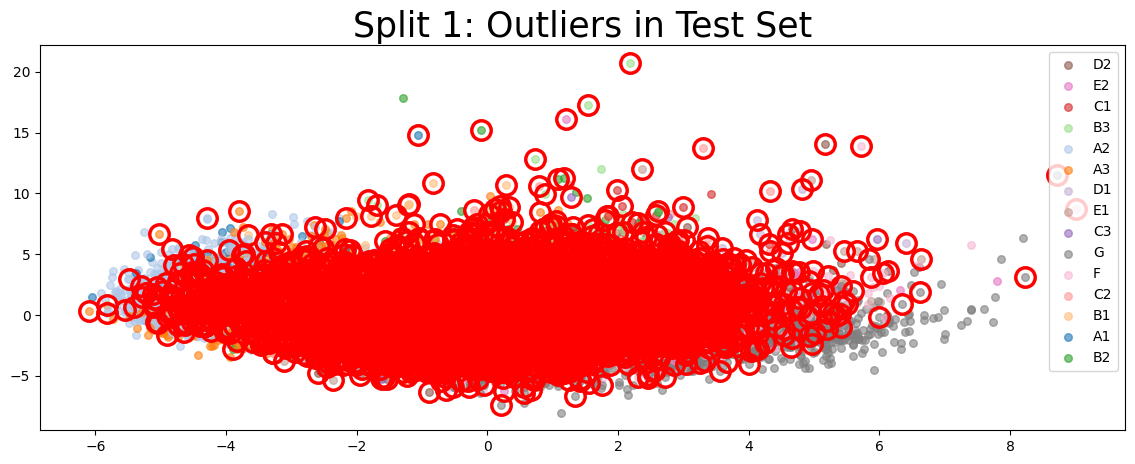

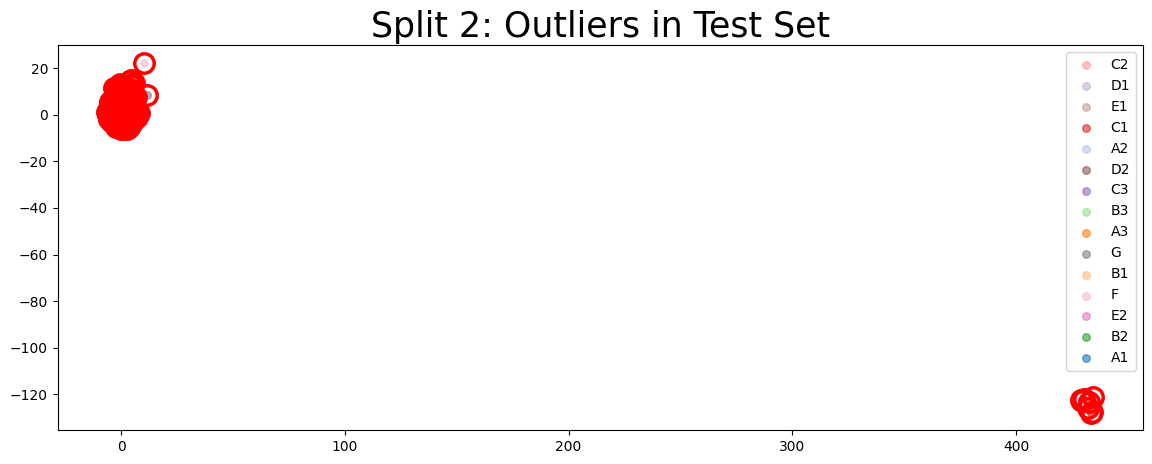

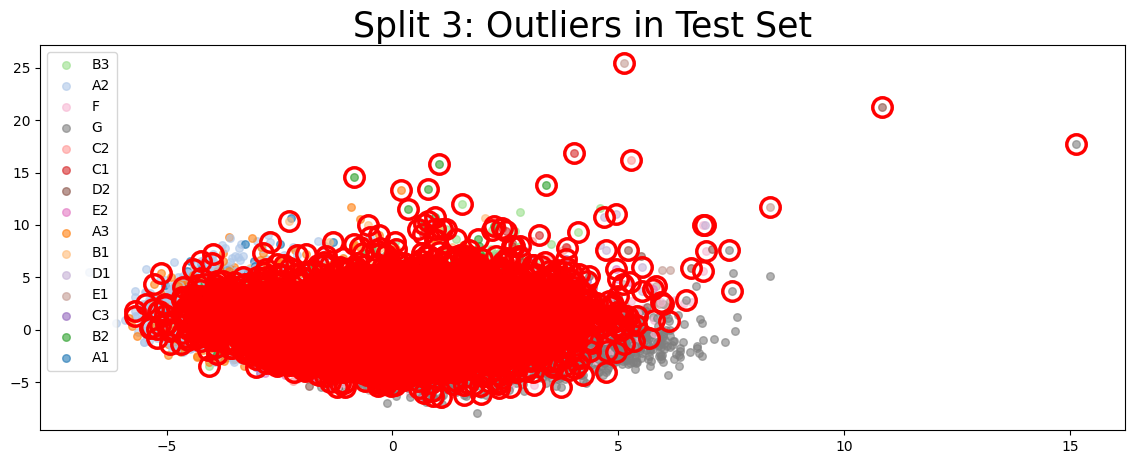

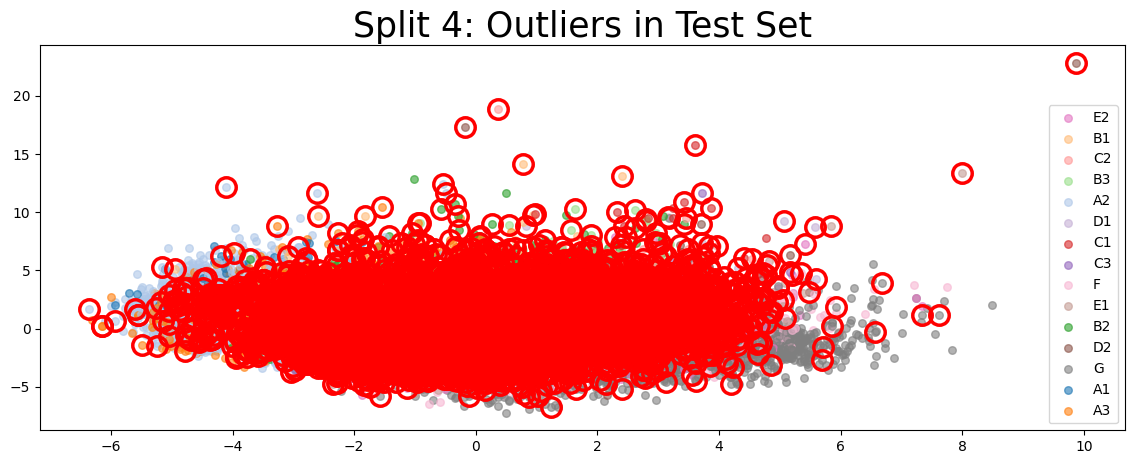

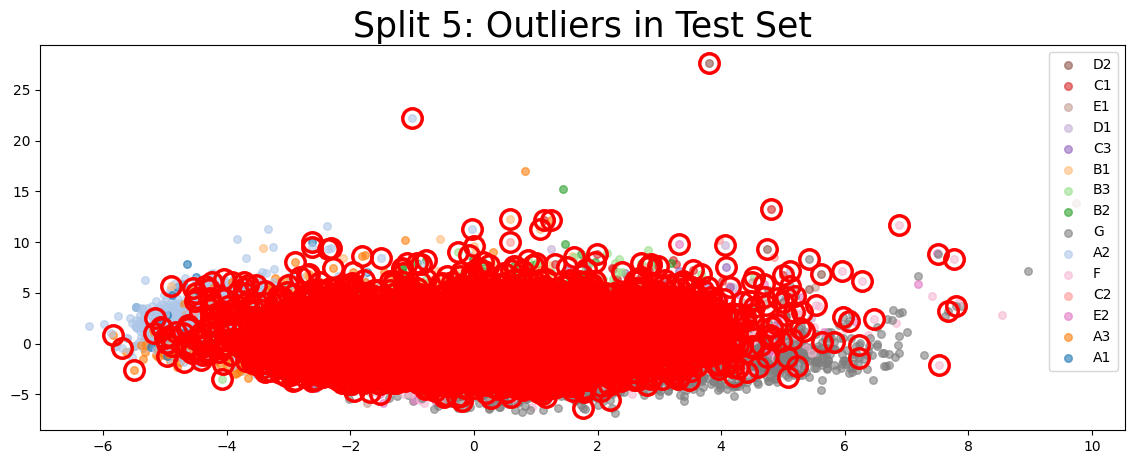

In [19]:
from cleanlab.outlier import OutOfDistribution
import numpy as np
from sklearn.decomposition import PCA

for i in range(n_splits):
    ood = OutOfDistribution()
    train_emb = np.load(f"{output_dir}/split_{i+1}/train.npy")
    test_emb = np.load(f"{output_dir}/split_{i+1}/test.npy")
    ood.fit_score(features=train_emb)
    ood_train_feature_scores = ood.score(features=train_emb)
    ood_test_feature_scores = ood.score(features=test_emb)
    train_outliers_idx = np.where(ood_train_feature_scores  < threshold)[0]
    test_outliers_idx = np.where(ood_test_feature_scores  < threshold)[0]
    train_df = pd.read_csv(f"{output_dir}/split_{i+1}/raw_train.csv")
    test_df = pd.read_csv(f"{output_dir}/split_{i+1}/raw_test.csv")
    save_csv_file(train_df.iloc[train_outliers_idx], f"{output_dir}/split_{i+1}/cleanlab/train_outliers.csv")
    save_csv_file(test_df.iloc[test_outliers_idx], f"{output_dir}/split_{i+1}/cleanlab/test_outliers.csv")
    save_csv_file(train_df[~train_df.index.isin(train_outliers_idx)], f"{output_dir}/split_{i+1}/cleanlab/train_removed_outliers.csv")
    save_csv_file(test_df[~test_df.index.isin(test_outliers_idx)], f"{output_dir}/split_{i+1}/cleanlab/test_removed_outliers.csv")
    
    pca = PCA(n_components=2)
    process_train_df = pd.read_csv(f"{output_dir}/split_{i+1}/processed_train.csv")
    
    process_test_df = pd.read_csv(f"{output_dir}/split_{i+1}/processed_test.csv")
    
    pca.fit(process_train_df.drop(columns=["EnergyRating"]))
    low_dim_train_features = pca.transform(process_train_df.drop(columns=["EnergyRating"]))
    low_dim_test_features = pca.transform(process_test_df.drop(columns=["EnergyRating"]))
    
    colormap = plt.cm.tab20
    colors = [colormap(i) for i in range(len(label_map))]
    
#     plot_data(low_dim_train_features, process_train_df["EnergyRating"], 
#               train_outliers_idx, 
#               title = f"Split {i+1}: Outliers in Training Set",
#              )
    plot_data(low_dim_test_features, process_test_df["EnergyRating"], 
              test_outliers_idx, 
              title = f"Split {i+1}: Outliers in Test Set",
             )

In [35]:
df = pd.read_csv("/kaggle/working/output/split_5/cleanlab/test_outliers.csv")
df_train =  pd.read_csv("/kaggle/working/output/split_5/raw_test.csv")
len(df)/len(df_train)

/tmp/ipykernel_34/1643745194.py:1: DtypeWarning: Columns (156,162,167) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/kaggle/working/output/split_5/cleanlab/test_outliers.csv")
/tmp/ipykernel_34/1643745194.py:2: DtypeWarning: Columns (156,162,167) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train =  pd.read_csv("/kaggle/working/output/split_5/raw_test.csv")


0.3998184518897508

In [36]:
"""Process train and test sets after their outliers are removed.
"""
for i in range(n_splits):
    command = f"""
    python /kaggle/working/scarf/get_processed_dataset.py \
      --config_dir "/kaggle/working/scarf/configs" \
      --output_dir "{output_dir}/split_{i+1}/cleanlab" \
      --data_path "{output_dir}/split_{i+1}/cleanlab/train_removed_outliers.csv" \
      --output_csv_name "processed_train" \
      --is_train
    """
    os.system(command)
    command = f"""
    python /kaggle/working/scarf/get_processed_dataset.py \
      --config_dir "/kaggle/working/scarf/configs" \
      --output_dir "{output_dir}/split_{i+1}/cleanlab" \
      --data_path "{output_dir}/split_{i+1}/cleanlab/test_removed_outliers.csv" \
      --output_csv_name "processed_test"
    """
    os.system(command)

**Train the MLP classifier on the datasets**

In [43]:
mlp_batch_size = 32
mlp_epochs = 20
mlp_lr = 0.00003
mlp_dropout= 0.1

**Before outlier removal**

In [44]:
for i in range(n_splits):
    command = f"""
    python /kaggle/working/scarf/run_mlp.py \
      --config_dir={config_dir} \
      --output_dir="{output_dir}/split_{i+1}/"\
      --train_data_path="{output_dir}/split_{i+1}/processed_train.csv" \
      --test_data_path="{output_dir}/split_{i+1}/cleanlab/processed_test.csv" \
      --batch_size={mlp_batch_size} \
      --epochs={mlp_epochs} \
      --lr={mlp_lr} \
      --model_name={mlp_model_name} \
      --wandb_project_name "test" \
      --wandb_entity "urbancomp" \
      --wandb_key {wandb_key} \
      --hidden_layer 256 128 64 32 16 \
      --dropout={mlp_dropout} 
    """

    os.system(command)

wandb: Currently logged in as: dan-liu. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dan-liu (urbancomp). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240609_164933-s20ok4kr
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run test
wandb: ⭐️ View project at https://wandb.ai/urbancomp/Scarf-MLP
wandb: 🚀 View run at https://wandb.ai/urbancomp/Scarf-MLP/runs/s20ok4kr


Model saved at /kaggle/working/output/split_1//mlp.pt
Epoch [1/20] - Train Loss: 1.928, Train Acc: 0.263, Train F1: 0.283, Test Loss: 1.617, Test Acc: 0.380, Test F1: 0.192
Model saved at /kaggle/working/output/split_1//mlp.pt
Epoch [2/20] - Train Loss: 1.738, Train Acc: 0.368, Train F1: 0.250, Test Loss: 1.406, Test Acc: 0.470, Test F1: 0.311
Model saved at /kaggle/working/output/split_1//mlp.pt
Epoch [3/20] - Train Loss: 1.729, Train Acc: 0.421, Train F1: 0.304, Test Loss: 1.306, Test Acc: 0.499, Test F1: 0.357
Model saved at /kaggle/working/output/split_1//mlp.pt
Epoch [4/20] - Train Loss: 1.188, Train Acc: 0.526, Train F1: 0.560, Test Loss: 1.247, Test Acc: 0.511, Test F1: 0.376
Model saved at /kaggle/working/output/split_1//mlp.pt
Epoch [5/20] - Train Loss: 1.465, Train Acc: 0.579, Train F1: 0.397, Test Loss: 1.213, Test Acc: 0.515, Test F1: 0.389
Model saved at /kaggle/working/output/split_1//mlp.pt
Epoch [6/20] - Train Loss: 1.431, Train Acc: 0.421, Train F1: 0.321, Test Loss: 1

wandb: - 0.030 MB of 0.030 MB uploaded
wandb: Run history:
wandb:      test/A1_acc ▁▁▁▁▁▁▁▁▁▁
wandb:      test/A2_acc █▆▄▂▂▁▁▂▃▃
wandb:      test/A3_acc ▁▅▆▇▇█████
wandb:      test/B1_acc ▁▁▁▁▁▁▁▁▁▁
wandb:      test/B2_acc ▁▁▁▁▄▃▇▇▇█
wandb:      test/B3_acc ▁▅▅▆▇▇████
wandb:      test/C1_acc ██▇▇▅▄▃▃▁▁
wandb:      test/C2_acc █▃▄▄▂▆▃▃▂▁
wandb:      test/C3_acc ▁▆▇▆█▇▇▆▇▆
wandb:      test/D1_acc ▂▂█▇▅▇▄▄▄▁
wandb:      test/D2_acc ▁█▆▇██▇▇▇▇
wandb:      test/E1_acc ▄▁▅▆▆▇█▇█▆
wandb:      test/E2_acc ▁▁▂▂▂▃▂▇▅█
wandb:       test/F_acc ▁▃▅▇███▆▇▆
wandb:       test/G_acc █▆▄▃▃▂▁▂▂▂
wandb:    test/test_acc ▁▆▇█████▇▇
wandb:     test/test_f1 ▁▅▇▇██████
wandb:   test/test_loss █▄▃▂���▁▁▁▁▂
wandb:         train/f1 ▁▃▃▅▃▅▄▄▅▄▅▅▅▃▇▆▅▅▄▅▆▅▃▄█▇▆▇▅▄▄▅▆▅▅▆▇█▄▆
wandb:  train/train_acc ▁▃▃▄▃▄▄▄▆▄▅▅▅▃▆▆▅▄▄▅▆▅▃▄█▆▇▅▆▅▄▅▇▆▅▅▇█▅▆
wandb: train/train_loss █▆▅▄▅▅▄▃▃▄▄▂▃▄▃▃▄▃▃▄▂▃▄▃▁▂▂▃▃▃▃▃▁▂▂▃▁▁▂▁
wandb: 
wandb: Run summary:
wandb:      test/A1_acc 0.0
wandb:      test/A2_acc 0.88223
wandb:      test/A3_acc 0.

Model saved at /kaggle/working/output/split_2//mlp.pt
Epoch [1/20] - Train Loss: 1.985, Train Acc: 0.211, Train F1: 0.151, Test Loss: 1.606, Test Acc: 0.409, Test F1: 0.232
Model saved at /kaggle/working/output/split_2//mlp.pt
Epoch [2/20] - Train Loss: 1.801, Train Acc: 0.211, Train F1: 0.109, Test Loss: 1.397, Test Acc: 0.458, Test F1: 0.300
Model saved at /kaggle/working/output/split_2//mlp.pt
Epoch [3/20] - Train Loss: 1.599, Train Acc: 0.368, Train F1: 0.257, Test Loss: 1.300, Test Acc: 0.496, Test F1: 0.356
Model saved at /kaggle/working/output/split_2//mlp.pt
Epoch [4/20] - Train Loss: 1.555, Train Acc: 0.368, Train F1: 0.217, Test Loss: 1.232, Test Acc: 0.511, Test F1: 0.372
Model saved at /kaggle/working/output/split_2//mlp.pt
Epoch [5/20] - Train Loss: 1.382, Train Acc: 0.368, Train F1: 0.256, Test Loss: 1.186, Test Acc: 0.535, Test F1: 0.408
Model saved at /kaggle/working/output/split_2//mlp.pt
Epoch [6/20] - Train Loss: 1.214, Train Acc: 0.632, Train F1: 0.589, Test Loss: 1

wandb: / 0.139 MB of 0.139 MB uploaded
wandb: Run history:
wandb:      test/A1_acc ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:      test/A2_acc █▃▁▁▁▃▁▁▂▄▄▃▂▄▃▃▃▃▄▃
wandb:      test/A3_acc ▁▄▅▆▆▆▇▇▇▇▇▇█▇██████
wandb:      test/B1_acc ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
wandb:      test/B2_acc ▁▁▁▁▃▃▃▃▄▅▅▇▆▆▇███▇▇
wandb:      test/B3_acc ▁▄▆▇▇▇█▇█▇█▇███████▇
wandb:      test/C1_acc ▇█▇▆▅▅▃▂▃▃▁▂▄▁▃▂▃▂▁▄
wandb:      test/C2_acc █▆▁▃▅▆▇▇▇▇▇██▇▇█▇▇▇▆
wandb:      test/C3_acc ▁▁▆▆▇▇▆▇▇▇▇▇▇█▇▇████
wandb:      test/D1_acc ▁▅▄▅▆▇▇▆▆▇█▇▆████▇██
wandb:      test/D2_acc ▁▂▄▄▆▅▆▇▇▇▇█▇███████
wandb:      test/E1_acc ▁▄▄▅���▅▆▆▆▆▆▇▅▆▇▇▆▇██
wandb:      test/E2_acc ▁▁▁▁▃▄▄▄▄▆▆▆▆▇▇▇▇█▆▇
wandb:       test/F_acc ▁▃▄▅▆▇▇██▇▇▇▇▇██▇███
wandb:       test/G_acc █▆▅▃▁▁▂▂▂▂▂▃▁▂▂▂▃▁▁▃
wandb:    test/test_acc ▁▃▄▅▅▆▆▇▇▇▇▇▇▇██████
wandb:     test/test_f1 ▁▃▄▅▆▆▆▇▇▇▇▇▇▇██████
wandb:   test/test_loss █▆▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
wandb:         train/f1 ▁▂▃▄▅▅▃▄▃▆▅▅▅▄▃▅▆▅▅▄▆█▆▅▅▆▇▇▅▅▃▄▅▅▇▇▇▇▅▅
wandb:  train/train_acc ▁▂▃▄▅▆▂▅▄▅▅▅▆▄▃▅▄▅▅▄▅█▆▆▄▆▆▇▆▆▅▄▆▅▆▇▇▇▅▆

Model saved at /kaggle/working/output/split_3//mlp.pt
Epoch [1/20] - Train Loss: 1.740, Train Acc: 0.368, Train F1: 0.298, Test Loss: 1.600, Test Acc: 0.395, Test F1: 0.211
Model saved at /kaggle/working/output/split_3//mlp.pt
Epoch [2/20] - Train Loss: 1.941, Train Acc: 0.211, Train F1: 0.155, Test Loss: 1.403, Test Acc: 0.453, Test F1: 0.299
Model saved at /kaggle/working/output/split_3//mlp.pt
Epoch [3/20] - Train Loss: 1.380, Train Acc: 0.474, Train F1: 0.297, Test Loss: 1.302, Test Acc: 0.492, Test F1: 0.340
Model saved at /kaggle/working/output/split_3//mlp.pt
Epoch [4/20] - Train Loss: 1.496, Train Acc: 0.526, Train F1: 0.443, Test Loss: 1.234, Test Acc: 0.514, Test F1: 0.372
Model saved at /kaggle/working/output/split_3//mlp.pt
Epoch [5/20] - Train Loss: 1.888, Train Acc: 0.368, Train F1: 0.337, Test Loss: 1.184, Test Acc: 0.531, Test F1: 0.400
Model saved at /kaggle/working/output/split_3//mlp.pt
Epoch [6/20] - Train Loss: 1.105, Train Acc: 0.684, Train F1: 0.750, Test Loss: 1

wandb: - 0.142 MB of 0.142 MB uploaded
wandb: Run history:
wandb:      test/A1_acc ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:      test/A2_acc █▄▂▁▁▂▂▂▂▂▁▁▂▂▃▂▁▂▂▂
wandb:      test/A3_acc ▁▅▆▇▇▆▇▇▇▇▇█▇▇▇▇████
wandb:      test/B1_acc ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
wandb:      test/B2_acc ▁▁▁▁▁▂▄▄▄▅▅▆▆▆▇▆▆▇▇█
wandb:      test/B3_acc ▁▂▄▆▆▇▇▇▇▇███▇▇██▇▇█
wandb:      test/C1_acc ▆█▆▄▃▃▃▂▂▂▂▃▂▂▁▁▂▁▂▂
wandb:      test/C2_acc ▇▂▁▂▄▄▆▇▇█▆▆█▇█▇▆▇▇▆
wandb:      test/C3_acc ▁▃▆▇▇▆▇▇▇▇▇▇▇██▇████
wandb:      test/D1_acc ▁▄▇▅▆▇▆███▇████▇███▇
wandb:      test/D2_acc ▁▃▄▄▅▅▅▆▇▆▇▇▆▇▇▇▇▇█▇
wandb:      test/E1_acc ▁▂▄▅���▆▆▆▇▇▆▇▇▇▆▇█▇██
wandb:      test/E2_acc ▁▁▁▁▄▄▄▅▇█▇▆▇▆▆█▇██▇
wandb:       test/F_acc ▁▃▂▅▅▅▆▆▆▆▆▇▆█▇▇█▇██
wandb:       test/G_acc █▅▆▅▁▃▁▂▃▂▃▃▄▂▁▅▃▄▃▁
wandb:    test/test_acc ▁▃▄▅▅▆▆▇▇▇▇▇▇▇▇█████
wandb:     test/test_f1 ▁▃▄▅▆▆▆▇▇▇▇▇▇█▇█████
wandb:   test/test_loss █▆▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
wandb:         train/f1 ▁▂▂▃▄▂▄▂▄▄▅▄▃▃▅▃▃▅▆▃▄▃▅▅▅▄▄▄▆▃▄▃█▄▆▅▆▄▃▃
wandb:  train/train_acc ▁▃▃▄▄▃▅▂▆▅▅▄▅▄▅▃▃▆▇▃▆▄▆▆▅▅▄▅▆▄▅▅█▄▆▅▆▄▃▄

Model saved at /kaggle/working/output/split_4//mlp.pt
Epoch [1/20] - Train Loss: 1.801, Train Acc: 0.263, Train F1: 0.196, Test Loss: 1.611, Test Acc: 0.399, Test F1: 0.220
Model saved at /kaggle/working/output/split_4//mlp.pt
Epoch [2/20] - Train Loss: 1.885, Train Acc: 0.263, Train F1: 0.168, Test Loss: 1.406, Test Acc: 0.462, Test F1: 0.305
Model saved at /kaggle/working/output/split_4//mlp.pt
Epoch [3/20] - Train Loss: 1.786, Train Acc: 0.263, Train F1: 0.201, Test Loss: 1.310, Test Acc: 0.491, Test F1: 0.351
Model saved at /kaggle/working/output/split_4//mlp.pt
Epoch [4/20] - Train Loss: 1.394, Train Acc: 0.421, Train F1: 0.241, Test Loss: 1.239, Test Acc: 0.513, Test F1: 0.379
Model saved at /kaggle/working/output/split_4//mlp.pt
Epoch [5/20] - Train Loss: 1.474, Train Acc: 0.368, Train F1: 0.232, Test Loss: 1.185, Test Acc: 0.533, Test F1: 0.404
Model saved at /kaggle/working/output/split_4//mlp.pt
Epoch [6/20] - Train Loss: 1.697, Train Acc: 0.421, Train F1: 0.292, Test Loss: 1

wandb: - 0.146 MB of 0.146 MB uploaded
wandb: Run history:
wandb:      test/A1_acc ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:      test/A2_acc █▃▂▁▂▃▂▃▂▂▃▂▄▃▄▃▃▄▂▂
wandb:      test/A3_acc ▁▄▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇██
wandb:      test/B1_acc ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅█
wandb:      test/B2_acc ▁▁▁▁▁▂▄▄▄▅▆▅█▆▇▇██▇█
wandb:      test/B3_acc ▁▆▅▆▇▇▇████████████▇
wandb:      test/C1_acc █▄▅▄▃▃▃▁▂▁▂▂▁▂▁▁▂▂▁▃
wandb:      test/C2_acc ▃▄▁▄▄▆▆▆▆▇▇▇▇▇█▇▇█▇▇
wandb:      test/C3_acc ▁▄▇▆▆▇▇▇▇▇▇▇▇███████
wandb:      test/D1_acc ▂▁▃▄▆▅▆▆▇▇▆▇▇▇▇▇█▇█▇
wandb:      test/D2_acc ▁▆▅▅▅▆▇▇▇▇▇▇▇███▇███
wandb:      test/E1_acc ▄▁▄▄���▅▅▆▆▆▆▇▇▆█▇▇▇█▇
wandb:      test/E2_acc ▁▁▂▃▄▅▆▆▆▇▇▆█▇█▆▇▇▇█
wandb:       test/F_acc ▁▂▃▄▅▆▆▆▆▆▆▆▇▇▇▇▇██▇
wandb:       test/G_acc █▆▅▄▂▁▂▁▄▂▃▂▁▃▃▂▂▃▂▃
wandb:    test/test_acc ▁▃▄▅▅▆▆▇▇▇▇▇████████
wandb:     test/test_f1 ▁▃▄▅▅▆▇▇▇▇▇▇████████
wandb:   test/test_loss █▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
wandb:         train/f1 ▁▄▃▄▄▅▄▃▅▅▃▇▆▄▆▅▅▅▆▆▆▆▆▅▆█▅▇▆▅▅▆█▇█▅▆▆▄▅
wandb:  train/train_acc ▁▅▂▃▃▅▃▁▅▅▁▆▅▄▇▅▄▃▆▅▆▄▇▄▅▆▅█▇▇▅▅▇▆█▆▆▇▃▆

Model saved at /kaggle/working/output/split_5//mlp.pt
Epoch [1/20] - Train Loss: 1.831, Train Acc: 0.400, Train F1: 0.245, Test Loss: 1.614, Test Acc: 0.393, Test F1: 0.219
Model saved at /kaggle/working/output/split_5//mlp.pt
Epoch [2/20] - Train Loss: 1.763, Train Acc: 0.400, Train F1: 0.264, Test Loss: 1.412, Test Acc: 0.451, Test F1: 0.294
Model saved at /kaggle/working/output/split_5//mlp.pt
Epoch [3/20] - Train Loss: 1.463, Train Acc: 0.350, Train F1: 0.286, Test Loss: 1.319, Test Acc: 0.480, Test F1: 0.343
Model saved at /kaggle/working/output/split_5//mlp.pt
Epoch [4/20] - Train Loss: 1.441, Train Acc: 0.500, Train F1: 0.475, Test Loss: 1.257, Test Acc: 0.502, Test F1: 0.368
Model saved at /kaggle/working/output/split_5//mlp.pt
Epoch [5/20] - Train Loss: 1.271, Train Acc: 0.750, Train F1: 0.544, Test Loss: 1.204, Test Acc: 0.525, Test F1: 0.394
Model saved at /kaggle/working/output/split_5//mlp.pt
Epoch [6/20] - Train Loss: 1.345, Train Acc: 0.450, Train F1: 0.357, Test Loss: 1

wandb: / 0.148 MB of 0.148 MB uploaded
wandb: Run history:
wandb:      test/A1_acc ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:      test/A2_acc █▅▂▁▁▁▂▃▃▂▃▂▃▂▂▃▃▂▁▂
wandb:      test/A3_acc ▁▄▆▆▇▇▆▆▆▇▇▇▇▇▇▇▇██▇
wandb:      test/B1_acc ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▅▃
wandb:      test/B2_acc ▁▁▁▁▂▃▄▃▅▅▅▄▆▇▇▇▇██▇
wandb:      test/B3_acc ▁▅▅▇▇▇▇▇▇▇███████▇██
wandb:      test/C1_acc █▇▆▅▄▄▂▂▂▃▂▂▂▁▁▂▃▂▁▃
wandb:      test/C2_acc ▅▄▃▁▃▄▆▆█▆▇██████▇▇▇
wandb:      test/C3_acc ▁▁▄▆▇▇▇▇▇▇▇▇▇▇▇▇▇███
wandb:      test/D1_acc ▁▅▆▅▅▆▆▆█▆▇█▇██▇▇█▇█
wandb:      test/D2_acc ▁▄▂▄▅▆▇▆▆▇▇▇▇█▇▇████
wandb:      test/E1_acc ▁▁▃▄���▆▅▇▅▆▆▆▇▇█▇▇▆█▇
wandb:      test/E2_acc ▁▁▄▂▃▄▅▅▆▆▇▇▇█▇▇▇█▇▇
wandb:       test/F_acc ▁▃▃▅▇▇▇▇▇▇▇▇▇▇▇▇████
wandb:       test/G_acc █▇▅▄▂▁▂▂▂▁▃▂▂▂▂▁▄▂▁▃
wandb:    test/test_acc ▁▃▄▅▅▆▆▇▇▇▇▇▇███████
wandb:     test/test_f1 ▁▃▄▅▆▆▆▇▇▇▇▇████████
wandb:   test/test_loss █▆▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
wandb:         train/f1 ▁▃▂▃▄▃▃▄▅▅▄▅▆▆▄▅▄▃▄▄▄▅▅▅▆▆▅▅▅▆▆▄▇▅▆▅█▄▅▅
wandb:  train/train_acc ▁▃▂▃▄▃▃▅▄▅▃▄▅▆▄▅▃▃▄▄▄▅▅▅▆▅▅▅▄▅▅▅▇▅▆▅█▅▆▅

**After outlier removal**

In [ ]:

for i in range(n_splits):
    command = f"""
    python /kaggle/working/scarf/run_mlp.py \
      --config_dir={config_dir} \
      --output_dir="{output_dir}/split_{i+1}/cleanlab"\
      --train_data_path="{output_dir}/split_{i+1}/cleanlab/processed_train.csv" \
      --test_data_path="{output_dir}/split_{i+1}/cleanlab/processed_test.csv" \
      --batch_size={mlp_batch_size} \
      --epochs={mlp_epochs} \
      --lr={mlp_lr} \
      --model_name={mlp_model_name} \
      --wandb_project_name "test" \
      --wandb_entity "urbancomp" \
      --wandb_key {wandb_key} \
      --hidden_layer 256 128 64 32 16 \
      --dropout={mlp_dropout} 
    """

    os.system(command)

wandb: Currently logged in as: dan-liu. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dan-liu (urbancomp). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240609_172958-gqex5av4
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run test
wandb: ⭐️ View project at https://wandb.ai/urbancomp/Scarf-MLP
wandb: 🚀 View run at https://wandb.ai/urbancomp/Scarf-MLP/runs/gqex5av4


Model saved at /kaggle/working/output/split_1/cleanlab/mlp.pt
Epoch [1/20] - Train Loss: 1.761, Train Acc: 0.318, Train F1: 0.211, Test Loss: 1.764, Test Acc: 0.345, Test F1: 0.154
Model saved at /kaggle/working/output/split_1/cleanlab/mlp.pt
Epoch [2/20] - Train Loss: 1.646, Train Acc: 0.364, Train F1: 0.209, Test Loss: 1.509, Test Acc: 0.422, Test F1: 0.250
Model saved at /kaggle/working/output/split_1/cleanlab/mlp.pt
Epoch [3/20] - Train Loss: 1.255, Train Acc: 0.455, Train F1: 0.371, Test Loss: 1.388, Test Acc: 0.456, Test F1: 0.297
Model saved at /kaggle/working/output/split_1/cleanlab/mlp.pt
Epoch [4/20] - Train Loss: 1.379, Train Acc: 0.455, Train F1: 0.325, Test Loss: 1.311, Test Acc: 0.482, Test F1: 0.331
Model saved at /kaggle/working/output/split_1/cleanlab/mlp.pt
Epoch [5/20] - Train Loss: 1.510, Train Acc: 0.409, Train F1: 0.251, Test Loss: 1.257, Test Acc: 0.501, Test F1: 0.357
Model saved at /kaggle/working/output/split_1/cleanlab/mlp.pt
Epoch [6/20] - Train Loss: 1.227,

wandb: / 0.148 MB of 0.148 MB uploaded
wandb: Run history:
wandb:      test/A1_acc ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:      test/A2_acc █▅▂▁▂▁▂▂▂▂▂▂▂▂▂▂▂▁▁▂
wandb:      test/A3_acc ▁▅▇▇▆▇▇▇▇▇▇▇▇▇▇▇███▇
wandb:      test/B1_acc ▁▁▁▁▁▁▁▁▂▂▅▄▅▅▅▇▇█▇▆
wandb:      test/B2_acc ▁▁▁▁▁▁▁▁▁▁▁▂▁▂▆▂▅▃▃█
wandb:      test/B3_acc ▁▂▄▄▅▆▇▇▇▇▇▇█▇▇██▇██
wandb:      test/C1_acc ▁███▇▇▇▇▆▇▆▆▆▇▆▆▆▆▇▆
wandb:      test/C2_acc █▂▂▁▁▂▂▂▃▂▃▃▃▂▃▃▃▃▃▃
wandb:      test/C3_acc ▁▁▁▄▅▅▅▅▆▆▆▇▇█▇▇██▇▇
wandb:      test/D1_acc ▁▃▄▅▇▇▇██▇█▇█▇▇▇▇▇█▆
wandb:      test/D2_acc ▁▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██▇█
wandb:      test/E1_acc ▁▂▃▃���▄▅▃▅▄▆▅▆▇▇█▇▇██
wandb:      test/E2_acc ▁▁▁▁▂▂▄▆▅▆▅▇▆▆▆▆█▇██
wandb:       test/F_acc ▁▁▂▃▄▅▆▆▇▇▇▇█▇▇█████
wandb:       test/G_acc █▇▇▆▅▄▄▃▂▃▂▁▂▃▄▃▃▃▂▄
wandb:    test/test_acc ▁▃▄▅▅▅▆▆▇▇▇▇▇███████
wandb:     test/test_f1 ▁▃▄▅▅▅▆▆▇▇▇▇▇▇██████
wandb:   test/test_loss █▆▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
wandb:         train/f1 ▁▂▄▂▃▂▆▄▃▂▇▄▄▃▄▄▄▅▅▇▃▆▃▅▅█▆▄▆▅▄▄▅▆▆▃▆█▃▅
wandb:  train/train_acc ▁▃▅▃▄▃▆▅▃▄▇▅▅▅▅▅▆▆▄▇▅▇▄▇▆▇▅▅▆▆▆▅▆▆▆▃▇█▅▇

Model saved at /kaggle/working/output/split_2/cleanlab/mlp.pt
Epoch [1/20] - Train Loss: 1.997, Train Acc: 0.250, Train F1: 0.219, Test Loss: 1.747, Test Acc: 0.344, Test F1: 0.147
Model saved at /kaggle/working/output/split_2/cleanlab/mlp.pt
Epoch [2/20] - Train Loss: 1.687, Train Acc: 0.350, Train F1: 0.294, Test Loss: 1.514, Test Acc: 0.422, Test F1: 0.246
Model saved at /kaggle/working/output/split_2/cleanlab/mlp.pt
Epoch [3/20] - Train Loss: 1.420, Train Acc: 0.300, Train F1: 0.187, Test Loss: 1.388, Test Acc: 0.459, Test F1: 0.298
Model saved at /kaggle/working/output/split_2/cleanlab/mlp.pt
Epoch [4/20] - Train Loss: 1.478, Train Acc: 0.450, Train F1: 0.438, Test Loss: 1.314, Test Acc: 0.486, Test F1: 0.337
Model saved at /kaggle/working/output/split_2/cleanlab/mlp.pt
Epoch [5/20] - Train Loss: 1.398, Train Acc: 0.500, Train F1: 0.279, Test Loss: 1.261, Test Acc: 0.501, Test F1: 0.357
Model saved at /kaggle/working/output/split_2/cleanlab/mlp.pt
Epoch [6/20] - Train Loss: 1.500,

wandb: - 0.139 MB of 0.139 MB uploaded
wandb: Run history:
wandb:      test/A1_acc ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:      test/A2_acc █▅▄▄▃▁▃▂▃▃▂▄▃▃▃▄▃▄▃▃
wandb:      test/A3_acc ▁▅▇▇▇▇▇▇▇▇█▇▇▇▇▇█▇██
wandb:      test/B1_acc ▁▁▁▁▁▁▁▁▁▁▁▃▃▅▃▆██▆▆
wandb:      test/B2_acc ▁▁▁▁▁▁▁▁▁▁▂▃▂▃▅▅▆▇██
wandb:      test/B3_acc ▁▂▄▅▆▅▆▇▇▇▇▇▇▇▇█▇███
wandb:      test/C1_acc ▁█▇█▇▇▆▆▆▆▆▆▆▇▇▆▆▆▆▆
wandb:      test/C2_acc █▂▃▁▁▂▃▃▃▃▃▃▃▃▃▃▄▃▄▄
wandb:      test/C3_acc ▁▁▁▅▅▆▆▆▆▇█▇█▇██████
wandb:      test/D1_acc ▁▄▅▄▆▅▆▇▇▇▇▇▆▇████▇▇
wandb:      test/D2_acc ▁▃▅▅▅▇▆▆▆▇▇▇▇█▇▇████
wandb:      test/E1_acc ▁▄▂▄���▃▅▄▆▆▇▆▇▇█▇█▇▇▇
wandb:      test/E2_acc ▁▁▁▁▂▃▂▄▄▄▄▆▅▅▆▆▆███
wandb:       test/F_acc ▁▁▃▃▃▄▆▆▇█▇███▇█████
wandb:       test/G_acc █▇▆▆▆▅▅▃▄▁▂▂▃▃▃▃▂▃▂▃
wandb:    test/test_acc ▁▃▄▅▅▆▆▆▆▇▇▇▇▇██████
wandb:     test/test_f1 ▁▃▄▅▅▆▆▆▇▇▇▇▇▇▇█████
wandb:   test/test_loss █▆▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
wandb:         train/f1 ▁▂▃▂▄▃▃▃▃▄▅▃▄▄▄▅▅▅▅▅▅▅▆▅▆▅▃▅▅▅▇▆▆▆▄█▅▄█▅
wandb:  train/train_acc ▁▄▄▁▅▃▃▁▃▄▇▃▃▄▄▄▄▄▅▅▃▅▆▅▇▇▃▅▄▅▇▇▆▅▅▇▅▃█▅

**Train the random forest on the datasets**

In [37]:
max_depth = 6

**Before outlier removal**

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
for i in range(n_splits):
    clf = RandomForestClassifier(max_depth=max_depth, random_state=42)
    train_df = pd.read_csv(f"{output_dir}/split_{i+1}/processed_train.csv")
    test_df = pd.read_csv(f"{output_dir}/split_{i+1}/cleanlab/processed_test.csv")
    clf.fit(train_df.drop(columns=["EnergyRating"]), train_df["EnergyRating"])
    acc = clf.score(test_df.drop(columns=["EnergyRating"]), test_df["EnergyRating"],
             )
    predict = clf.predict(test_df.drop(columns=["EnergyRating"]))
    f1 = f1_score(test_df["EnergyRating"], predict,average='macro')
    print(f"Split: {i+1}, Accuracy: {acc}, F1 Score: {f1}")

Split: 1, Accuracy: 0.44224913728939713, F1 Score: 0.2882089265235367
Split: 2, Accuracy: 0.4416871752802844, F1 Score: 0.28793912501665225
Split: 3, Accuracy: 0.43568236507390856, F1 Score: 0.28234742127266627
Split: 4, Accuracy: 0.4329734900245969, F1 Score: 0.28091351706000334
Split: 5, Accuracy: 0.4324900316238141, F1 Score: 0.28174192507615514


**After outlier removal**

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
for i in range(n_splits):
    clf = RandomForestClassifier(max_depth=max_depth, random_state=42)
    train_df = pd.read_csv(f"{output_dir}/split_{i+1}/cleanlab/processed_train.csv")
    test_df = pd.read_csv(f"{output_dir}/split_{i+1}/cleanlab/processed_test.csv")
    clf.fit(train_df.drop(columns=["EnergyRating"]), train_df["EnergyRating"])
    acc = clf.score(test_df.drop(columns=["EnergyRating"]), test_df["EnergyRating"],
             )
    predict = clf.predict(test_df.drop(columns=["EnergyRating"]))
    f1 = f1_score(test_df["EnergyRating"], predict,average='macro')
    print(f"Split: {i+1}, Accuracy: {acc}, F1 Score: {f1}")

Split: 1, Accuracy: 0.4515867108735368, F1 Score: 0.29417909292323985
Split: 2, Accuracy: 0.45344544708777684, F1 Score: 0.29450402634215755
Split: 3, Accuracy: 0.44338260570642835, F1 Score: 0.2853249374030616
Split: 4, Accuracy: 0.4426755944247062, F1 Score: 0.2853195304533711
Split: 5, Accuracy: 0.44293963976350886, F1 Score: 0.2887587495775062
